# 1 Построение первой версии модели и тестирование гипотез

### 1.1 Импортируем библиотеки и загрузим данные

In [1]:
import pandas as pd # работа с таблицами 
import numpy as np # математические функции и матрицы
import matplotlib.pyplot as plt # графики
import seaborn as sns # еще более классные графики
import statsmodels.api as sm # стандартные регрессионные модели
import statsmodels.formula.api as smf # аналогичные модели с синтаксисом в стиле R
import statsmodels.graphics.gofplots as gf # визуализация моделей
import statsmodels.discrete.discrete_model # дискретные модели
from statsmodels.stats.outliers_influence import summary_table # работа с выбросами
from scipy.stats import shapiro # тест Шапиро – Уилка `

In [2]:
df_short = pd.read_csv('prepocessed_laptops_for_model.csv')
df_short = df_short.iloc[:, 1:]
df_short.head()

,Company,TypeName,Cpu,Ram,Gpu,OpSys,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,Intel Graphics,Without OS,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,AMD,Windows,400.00,1366.0


In [3]:
df_full = pd.read_csv('prepocessed_laptops_for_model_more_features.csv')
df_full = df_full.iloc[:, 1:]
df_full.head()

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,Mac,1.37,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,128.0,Intel Graphics,Mac,1.34,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,256.0,Intel Graphics,Without OS,1.86,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,256.0,Intel Graphics,Mac,1.37,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,500.0,AMD,Windows,2.10,400.00,1366.0


### 1.2 Гипотеза 1:

Признаки Memory, Weight являются статистически незначимыми (напомню, что в результате графического анализа мы пришли к выводу, что, скорее всего, эти признаки не нужны)

Для этого мы обучим модель сразу на всех признаках (включая dummy переменные), и посмотрим на t-статистики признаков, которые нас интересуют

За основу построения модели возьмем скрипт https://github.com/pvpogorelova/ec_metrics/blob/main/Sem_08.ipynb

In [4]:
df_reg = pd.get_dummies(df_full, drop_first=True)
df_reg.head()

cols = df_reg.columns
cols = [i.replace(' ', '_') for i in cols]
cols = [i.replace('/', '_') for i in cols]
df_reg.columns = cols
df_reg.head()

df_reg1 = df_reg.drop('Price_euros', axis=1)
text = ''
for i in list(df_reg1.columns):
    text += f'+ {i} '
text
text = text[1:]
text

' Ram + Memory + Weight + ScreenResolution_width + Company_Apple + Company_Asus + Company_Chuwi + Company_Dell + Company_Fujitsu + Company_Google + Company_HP + Company_Huawei + Company_LG + Company_Lenovo + Company_MSI + Company_Mediacom + Company_Microsoft + Company_Razer + Company_Samsung + Company_Toshiba + Company_Vero + Company_Xiaomi + TypeName_Gaming + TypeName_Netbook + TypeName_Notebook + TypeName_Ultrabook + TypeName_Workstation + Cpu_Intel_Core_i3 + Cpu_Intel_Core_i5 + Cpu_Intel_Core_i7 + Cpu_Intel_Other + Cpu_Other + Gpu_ARM + Gpu_Intel_Graphics + Gpu_Nvidia_GeForce + Gpu_Nvidia_Quadro_GTX + OpSys_Chrome + OpSys_Linux + OpSys_Mac + OpSys_Windows + OpSys_Without_OS '

In [5]:
ols_2 = smf.ols(f'Price_euros ~ {text}', data=df_reg).fit()
print(ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     82.21
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.83e-300
Time:                        16:30:21   Log-Likelihood:                -8426.8
No. Observations:                1184   AIC:                         1.693e+04
Df Residuals:                    1144   BIC:                         1.714e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -392

Нулевая гипотеза о том, что признак веса незначим, не отвергается на любом разумном уровне значимости. При этом нельзя сказать то же самое про память. Проблема в том, что коэффициент при факторе память отрицательный, то есть, по логике модели, при уменьшении памяти ноутбука, его цена увеличится. Это кажется контринтуитивным. Поэтому есть смысл выкинуть эту переменную из анализа, так как ни к чему плохому это не приведет

# Сразу заметим одну важную вещь! Обратим внимание, что OpSys_Mac и Company_Apple имеют одинаковый коэффициент. Это в целом логично, так как вряд ли операционную систему Mac можно встретить не у компании Apple. Это очень сильная мультиколлинеарность и нарушение одной из предпосылок ТГМ. При этом мы все равно будем эти предпосылки проверять, и поэтому проблему устраним чуть позже

###### Построим модель без этих признаков и посмотрим, стало ли лучше качество

In [6]:
df_reg = pd.get_dummies(df_short, drop_first=True)
df_reg.head()

cols = df_reg.columns
cols = [i.replace(' ', '_') for i in cols]
cols = [i.replace('/', '_') for i in cols]
df_reg.columns = cols
df_reg.head()

df_reg1 = df_reg.drop('Price_euros', axis=1)
text = ''
for i in list(df_reg1.columns):
    text += f'+ {i} '
text
text = text[1:]

ols_2 = smf.ols(f'Price_euros ~ {text}', data=df_reg).fit()
print(ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     86.32
Date:                Tue, 09 May 2023   Prob (F-statistic):          3.40e-301
Time:                        16:30:21   Log-Likelihood:                -8429.2
No. Observations:                1184   AIC:                         1.693e+04
Df Residuals:                    1146   BIC:                         1.713e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -383

###### Качество не улучшилось, но как будто бы и не ухудшилось. Поэтому теперь будем работать только с короткой версией датасета

### 1.3 Гипотеза 2:

Модель в целом значима. Примем последнюю модель, с которой мы работали, за базовую (то есть финальная модель будет ли эта, либо модель, у которой коэффициент $R^2$ не хуже). Поэтому мы сразу можем протестировать гипотезу о значимости модели в целом

In [7]:
pvalue = 3.40e-301

if pvalue < 0.01:
    print('Коэффициент R2 > 0 на 99% доверительном интервале, то есть модель значима')
else:
    print('You messed up')

Коэффициент R2 > 0 на 99% доверительном интервале, то есть модель значима


### 1.4 Гипотеза 3:

Категориальный признак компания важнее всех остальных признаков

In [8]:
df_short.head()

,Company,TypeName,Cpu,Ram,Gpu,OpSys,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,Intel Graphics,Without OS,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,AMD,Windows,400.00,1366.0


In [9]:
df_short1 = df_short[['Company', 'Price_euros']]
df_reg = pd.get_dummies(df_short1, drop_first=True)
df_reg.head()

cols = df_reg.columns
cols = [i.replace(' ', '_') for i in cols]
cols = [i.replace('/', '_') for i in cols]
df_reg.columns = cols
df_reg.head()

df_reg1 = df_reg.drop('Price_euros', axis=1)
text = ''
for i in list(df_reg1.columns):
    text += f'+ {i} '
text
text = text[1:]

ols_2 = smf.ols(f'Price_euros ~ {text}', data=df_reg).fit()
print(ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     18.07
Date:                Tue, 09 May 2023   Prob (F-statistic):           9.95e-51
Time:                        16:30:21   Log-Likelihood:                -9071.7
No. Observations:                1184   AIC:                         1.818e+04
Df Residuals:                    1165   BIC:                         1.828e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           648.5155     54.36

In [10]:
df_short2 = df_short[['Ram', 'ScreenResolution_width', 'Price_euros']]
df_reg = df_short2.copy()
df_reg.head()

cols = df_reg.columns
cols = [i.replace(' ', '_') for i in cols]
cols = [i.replace('/', '_') for i in cols]
df_reg.columns = cols
df_reg.head()

df_reg1 = df_reg.drop('Price_euros', axis=1)
text = ''
for i in list(df_reg1.columns):
    text += f'+ {i} '
text
text = text[1:]

ols_2 = smf.ols(f'Price_euros ~ {text}', data=df_reg).fit()
print(ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     718.4
Date:                Tue, 09 May 2023   Prob (F-statistic):          7.36e-205
Time:                        16:30:21   Log-Likelihood:                -8746.3
No. Observations:                1184   AIC:                         1.750e+04
Df Residuals:                    1181   BIC:                         1.751e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -255

Тут явно видно, что оперативная память и разрешение экрана описывают цену намного лучше, чем бренд, Поэтому гипотеза (в верности которой мы изначально были достаточно сильно уверены) отвергается, что позволяет сделать интересный результат

# 2 Проверка выполнения предпосылок ТГМ

По-хорошему, это надо было бы сделать намного раньше. Но при этом в контексте этого в принципе не особо важно, выполняются ли эти предпосылки, или нет, все равно будем использовать ЛинРег и выбранный датасет :) 

Для проверки предпосылок ТГМ будем использовать статью https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

### 2.1 Матожидание остатков равно нулю

In [11]:
ols_2.resid.mean()

4.4588861131873075e-11

Предпосылка явно выполнена

### 2.2 Отсутствие мультиколлинеарности

В статье есть хорошие готовые скрипты, поэтому воспользуюсь ими

In [12]:
for_analysis = df_short.copy()
for_analysis = pd.get_dummies(for_analysis, drop_first=True)
X = df_short.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short['Price_euros']

In [13]:
import statsmodels.api as sm

X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     86.32
Date:                Tue, 09 May 2023   Prob (F-statistic):          3.40e-301
Time:                        16:30:21   Log-Likelihood:                -8429.2
No. Observations:                1184   AIC:                         1.693e+04
Df Residuals:                    1146   BIC:                         1.713e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -383.0937    229.243     -1.671      0.095    -832.877      66.689
Ram                       53.4321      3.221     16.591      0.000      47.113      59.751
ScreenResolution_width     0.2162      0.023      9.225      0.000       0.170       0.262
Company_Apple            247.8452    117.330      2.112      0.035      17.640     478.051
Company_Asus             104.3235     42.901      2.432      0.015      20.151     188.496
Company_Chuwi           -156.2291    220.499     -0.709      0.479    -588.856     276.397
Company_Dell             100.0553     39.881      2.509      0.012      21.807     178.304
Company_Fujitsu            6.7136    179.756      0.037      0.970    -345.974     359.401
Company_Google           232.5519    204.894      1.135      0.257    -169.458     634.562
Company_HP               185.8145     39.145      4.747      0.000     109.010     262.619
Company_Huawei           121.5624    219.172      0.555      0.579    -308.461     551.586
Company_LG               667.6251    181.011      3.688      0.000     312.476    1022.775
Company_Lenovo           149.7820     39.781      3.765      0.000      71.730     227.834
Company_MSI              284.9211     62.110      4.587      0.000     163.059     406.783
Company_Mediacom        -116.2619    124.907     -0.931      0.352    -361.333     128.809
Company_Microsoft        246.2166    142.786      1.724      0.085     -33.936     526.369
Company_Razer           1328.4814    125.633     10.574      0.000    1081.985    1574.978
Company_Samsung          270.7491    122.053      2.218      0.027      31.276     510.222
Company_Toshiba          289.7129     56.956      5.087      0.000     177.962     401.463
Company_Vero            -129.0897    159.638     -0.809      0.419    -442.304     184.125
Company_Xiaomi           230.4859    161.080      1.431      0.153     -85.558     546.530
TypeName_Gaming           54.2382     48.666      1.114      0.265     -41.247     149.723
TypeName_Netbook         173.5851     94.685      1.833      0.067     -12.191     359.361
TypeName_Notebook       -163.4784     34.946     -4.678      0.000    -232.044     -94.913
TypeName_Ultrabook       135.4302     38.776      3.493      0.000      59.351     211.509
TypeName_Workstation     116.3676    117.591      0.990      0.323    -114.351     347.086
Cpu_Intel Core i3         -3.6624     58.983     -0.062      0.950    -119.389     112.064
Cpu_Intel Core i5        182.6454     54.761      3.335      0.001      75.202     290.089
Cpu_Intel Core i7        259.3236     55.783      4.649      0.000     149.875     368.772
Cpu_Intel Other         -113.7548     65.600     -1.734      0.083    -242.465      14.956
Cpu_Other               -102.3880    172.250     -0.594      0.552    -440.348  

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
vif_df = pd.DataFrame({'vif': vif[1:]}, index=X.columns)
vif_df.head()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,vif
Ram,2.118286
ScreenResolution_width,1.449053
Company_Apple,inf
Company_Asus,2.445111
Company_Chuwi,1.051230


В идеале все значения должны быть равны 1. Понятное дело, что в реальной жизни такого никогда не будет. Тем не менее, судя по значению коэффициентов, мультиколлинеарность у нас точно есть (напомню, что до этого мы от нее избавлялись, но после кодирования категориальных переменных они появилась снова). Решать проблему будем следующим образом:

1) Возьмем признаки с vif > 10 и посмотрим на их корреляцию с таргетом

2) На основе корреляции будем отбирать признаки до тех пор, пока все значения vif не будут превосходить 10

<span style="color:pink">Также, чтобы хоть как-то скрасить этот ужас, предлагаю построить матрицу корреляций в розовом цвете</span>

In [15]:
vif_df.loc[vif_df['vif'] >= 10]

,vif
Company_Apple,inf
Cpu_Other,inf
Gpu_ARM,inf
OpSys_Chrome,27.870903
OpSys_Mac,inf
OpSys_Windows,68.505521
OpSys_Without OS,30.907911


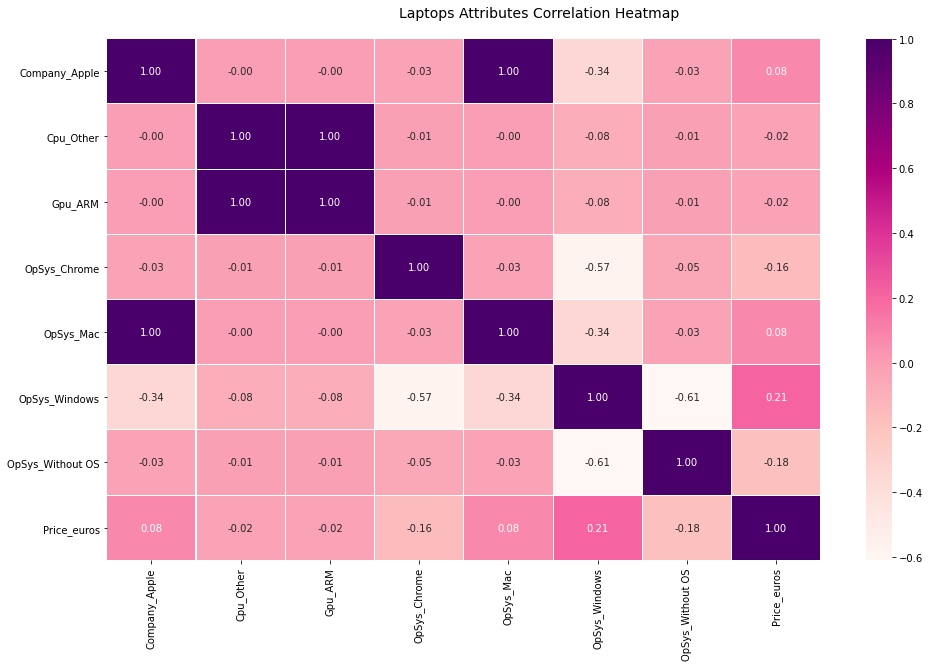

In [16]:
X_partial = for_analysis[['Company_Apple', 'Cpu_Other', 'Gpu_ARM', 'OpSys_Chrome', 'OpSys_Mac', 'OpSys_Windows', 'OpSys_Without OS', 'Price_euros']]
f, ax = plt.subplots(figsize = (10, 6))
corr = X_partial.corr()
hm = sns.heatmap(round(corr,2), annot = True, ax = ax, cmap = "RdPu", fmt = '.2f', linewidths = .05)
f.subplots_adjust(top = .93)
t= f.suptitle('Laptops Attributes Correlation Heatmap', fontsize = 14)
plt.gcf().set_size_inches(16, 9)

In [17]:
X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
vif_df = pd.DataFrame({'vif': vif[1:]}, index=X.columns)
vif_df.loc[vif_df['vif'] >= 10]

,vif


In [18]:
vif_df.loc[vif_df['vif'] >= 5]

,vif
Cpu_Intel Core i5,8.828710
Cpu_Intel Core i7,9.522204


##### Объяснение проблемы мультиколлинеарности на примере процессоров. Мы видим, что интел 5 и интел 7 у примерно 75% ноутбуков. При этом если у ноутбука интел 5, у него уже не может быть интел 7. Это объясняет сильную отрицательную корреляцию между некоторыми категориальными переменными. В принципе, это результат несбалансированности категориальных переменных

In [19]:
len(df_short.loc[(df_short['Cpu'] == 'Intel Core i5') | (df_short['Cpu'] == 'Intel Core i7')]) / len(df_short)

0.7508445945945946

##### Избавившись от трех признаков, мы смогли решить проблему. При этом мы еще и оценили модель. Посмотрим, какой получился результат

In [20]:
# то же самое, что и было
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     88.79
Date:                Tue, 09 May 2023   Prob (F-statistic):          3.59e-302
Time:                        16:30:24   Log-Likelihood:                -8429.2
No. Observations:                1184   AIC:                         1.693e+04
Df Residuals:                    1147   BIC:                         1.712e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -368.5511     87.858     -4.195      0.000    -540.932    -196.170
Ram                       53.4367      3.219     16.603      0.000      47.122      59.752
ScreenResolution_width     0.2162      0.023      9.229      0.000       0.170       0.262
Company_Apple            480.9522     94.956      5.065      0.000     294.645     667.259
Company_Asus             104.3784     42.875      2.434      0.015      20.257     188.500
Company_Chuwi           -155.8856    220.346     -0.707      0.479    -588.213     276.442
Company_Dell             100.0610     39.864      2.510      0.012      21.847     178.275
Company_Fujitsu            6.6138    179.672      0.037      0.971    -345.909     359.137
Company_Google           232.0413    204.670      1.134      0.257    -169.529     633.612
Company_HP               185.8067     39.128      4.749      0.000     109.036     262.578
Company_Huawei           121.5497    219.077      0.555      0.579    -308.287     551.386
Company_LG               667.5922    180.932      3.690      0.000     312.598    1022.586
Company_Lenovo           149.7774     39.764      3.767      0.000      71.760     227.795
Company_MSI              284.8948     62.082      4.589      0.000     163.088     406.702
Company_Mediacom        -115.8709    124.723     -0.929      0.353    -360.581     128.839
Company_Microsoft        246.2976    142.720      1.726      0.085     -33.723     526.318
Company_Razer           1328.4453    125.577     10.579      0.000    1082.059    1574.832
Company_Samsung          270.7472    122.000      2.219      0.027      31.379     510.116
Company_Toshiba          289.6428     56.923      5.088      0.000     177.959     401.327
Company_Vero            -128.7474    159.490     -0.807      0.420    -441.673     184.178
Company_Xiaomi           230.8476    160.924      1.435      0.152     -84.890     546.585
TypeName_Gaming           54.4949     48.501      1.124      0.261     -40.667     149.656
TypeName_Netbook         174.0152     94.437      1.843      0.066     -11.273     359.304
TypeName_Notebook       -163.1556     34.614     -4.714      0.000    -231.069     -95.242
TypeName_Ultrabook       135.6772     38.592      3.516      0.000      59.959     211.395
TypeName_Workstation     116.6327    117.477      0.993      0.321    -113.861     347.127
Cpu_Intel Core i3         -3.6311     58.955     -0.062      0.951    -119.304     112.042
Cpu_Intel Core i5        182.6652     54.737      3.337      0.001      75.270     290.061
Cpu_Intel Core i7        259.3476     55.758      4.651      0.000     149.949     368.746
Cpu_Intel Other         -114.1522     65.316     -1.748      0.081    -242.305      14.001
Gpu_ARM                 -204.9296    344.343     -0.595      0.552    -880.542  

### 2.3 Гомоскедастичность

Для проверки нулевой гипотезы о гомоскедастичности ошибок будем использовать тест Уайта и тест Бройша-Пагана

In [21]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
_, bp_pvalue, _, _ = het_breuschpagan(lin_reg.resid, X)
bp_pvalue

4.101446026504286e-98

In [22]:
white_test = het_white(lin_reg.resid, X)
white_test[1]

6.441644850077983e-79

In [23]:
bp_pvalue < 0.05

True

In [24]:
white_test[1] < 0.05

True

Оба теста очень уверенно показали, что у нас есть проблема гетероскедастичности (p-value в обоих случаях равны 0, то есть гипотеза о гомоскедастичности отвергается на любом уровне значимости). Скорее всего, это вызвано тем, что у нас есть разные группы объектов (которые определяются категориальными переменными), соответственно, какие-то мы предсказываем лучше, а какие-то - хуже. Проблема в том, что мы вряд ли можем решить эту проблему. Объясню почему те или иные способы не подходят в рамках нашего анализа:

1) Взвешенный МНК - не кажется, что какие-то ноутбуки важнее других, и хочется получить наиболее обобщенную модель

2) Кластеризация объектов и отдельная работа с каждой образовавшейся группой - опять же, хочется обобщенную модель

3) Нелинейное преобразование - можно попробовать, но мне кажется, что дело все же в dummy переменных, поэтому условное логарифмирование тут тоже не поможет

4) Использование более сложной модели - мы придем к этому в секции с более сложным анализом, но это уже будет нелинейная модель

### 2.4 Некоррелированность ошибок

In [25]:
dw = sm.stats.stattools.durbin_watson(lin_reg.resid)
dw

1.9663598037177505

В идеале значение должно равняться двум. У нас почти 2, то есть нет оснований отвергать $H_0$

### 2.5 Некоррелированность признаков и остатков

In [26]:
from scipy.stats.stats import pearsonr

for column in X.columns:
    corr_test = pearsonr(X[column], lin_reg.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')


Variable: Ram --- correlation: 0.0000, p-value: 1.0000
Variable: ScreenResolution_width --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Apple --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Asus --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Chuwi --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Dell --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Fujitsu --- correlation: -0.0000, p-value: 1.0000
Variable: Company_Google --- correlation: 0.0000, p-value: 1.0000
Variable: Company_HP --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Huawei --- correlation: -0.0000, p-value: 1.0000
Variable: Company_LG --- correlation: -0.0000, p-value: 1.0000
Variable: Company_Lenovo --- correlation: 0.0000, p-value: 1.0000
Variable: Company_MSI --- correlation: -0.0000, p-value: 1.0000
Variable: Company_Mediacom --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Microsoft --- correlation: 0.0000, p-value: 1.0000
Variable: Company_Ra

Предпосылка выполнена

### 2.6 Нормальность распределения ошибок

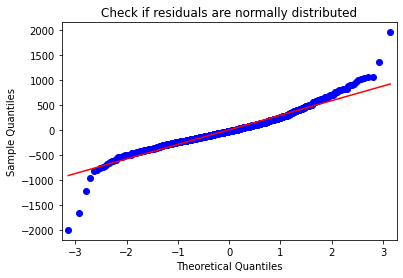

In [27]:
sm.qqplot(lin_reg.resid, line='r')
plt.title('Check if residuals are normally distributed')
plt.show()

Точки на графике не сильно отклоняются от прямой, поэтому нет оснований отвергать нулевую гипотезу о том, что ошибки распределены нормально

# 3 Экспериментируем и улучшаем модель

### 3.1 Вспомним, какое лучшее качество мы имеем на данный момент (с учетом избавления от признаков и борьбы с мультиколлинеарностью)

In [28]:
df_short.head()

,Company,TypeName,Cpu,Ram,Gpu,OpSys,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,Intel Graphics,Without OS,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,AMD,Windows,400.00,1366.0


In [29]:
X = df_short.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short['Price_euros']

X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     88.79
Date:                Tue, 09 May 2023   Prob (F-statistic):          3.59e-302
Time:                        16:30:26   Log-Likelihood:                -8429.2
No. Observations:                1184   AIC:                         1.693e+04
Df Residuals:                    1147   BIC:                         1.712e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -368.5511     87.858     -4.195      0.000    -540.932    -196.170
Ram                       53.4367      3.219     16.603      0.000      47.122      59.752
ScreenResolution_width     0.2162      0.023      9.229      0.000       0.170       0.262
Company_Apple            480.9522     94.956      5.065      0.000     294.645     667.259
Company_Asus             104.3784     42.875      2.434      0.015      20.257     188.500
Company_Chuwi           -155.8856    220.346     -0.707      0.479    -588.213     276.442
Company_Dell             100.0610     39.864      2.510      0.012      21.847     178.275
Company_Fujitsu            6.6138    179.672      0.037      0.971    -345.909     359.137
Company_Google           232.0413    204.670      1.134      0.257    -169.529     633.612
Company_HP               185.8067     39.128      4.749      0.000     109.036     262.578
Company_Huawei           121.5497    219.077      0.555      0.579    -308.287     551.386
Company_LG               667.5922    180.932      3.690      0.000     312.598    1022.586
Company_Lenovo           149.7774     39.764      3.767      0.000      71.760     227.795
Company_MSI              284.8948     62.082      4.589      0.000     163.088     406.702
Company_Mediacom        -115.8709    124.723     -0.929      0.353    -360.581     128.839
Company_Microsoft        246.2976    142.720      1.726      0.085     -33.723     526.318
Company_Razer           1328.4453    125.577     10.579      0.000    1082.059    1574.832
Company_Samsung          270.7472    122.000      2.219      0.027      31.379     510.116
Company_Toshiba          289.6428     56.923      5.088      0.000     177.959     401.327
Company_Vero            -128.7474    159.490     -0.807      0.420    -441.673     184.178
Company_Xiaomi           230.8476    160.924      1.435      0.152     -84.890     546.585
TypeName_Gaming           54.4949     48.501      1.124      0.261     -40.667     149.656
TypeName_Netbook         174.0152     94.437      1.843      0.066     -11.273     359.304
TypeName_Notebook       -163.1556     34.614     -4.714      0.000    -231.069     -95.242
TypeName_Ultrabook       135.6772     38.592      3.516      0.000      59.959     211.395
TypeName_Workstation     116.6327    117.477      0.993      0.321    -113.861     347.127
Cpu_Intel Core i3         -3.6311     58.955     -0.062      0.951    -119.304     112.042
Cpu_Intel Core i5        182.6652     54.737      3.337      0.001      75.270     290.061
Cpu_Intel Core i7        259.3476     55.758      4.651      0.000     149.949     368.746
Cpu_Intel Other         -114.1522     65.316     -1.748      0.081    -242.305      14.001
Gpu_ARM                 -204.9296    344.343     -0.595      0.552    -880.542  

In [30]:
pd.set_option('display.max_columns', 40)
df_short.head()

,Company,TypeName,Cpu,Ram,Gpu,OpSys,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1339.69,2560.0
1,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,898.94,1440.0
2,HP,Notebook,Intel Core i5,8.0,Intel Graphics,Without OS,575.00,1920.0
3,Apple,Ultrabook,Intel Core i5,8.0,Intel Graphics,Mac,1803.60,2560.0
4,Acer,Notebook,AMD,4.0,AMD,Windows,400.00,1366.0


### 3.2 Оценим еще 3 модели:

##### 3.2.1 Предсказываем логарифм таргета.

##### 3.2.2 Предсказываем таргет, но логарифмируем непрерывные признаки, не трогая категориальные.

##### 3.2.3 Как 3.2.2, только предсказываем логарифм таргета.

Всего у нас получится 4 модели (будем обращаться к ним в дальнейшем по номерам):

1) $\hat{y} = w_0 + x^Tw$; Эту модель мы уже оценили.

2) $log(\hat{y}) = w_0 + x^Tw$; как 1), только мы предсказываем логарифм таргета.

3) $\hat{y} = w_0 + w_{R}log(x_R) + w_{S}log(x_S) + \sum_{i \in cat} w_ix_i$;  предсказываем таргет, но логарифмируем непрерывные признаки, не трогая категориальные.

4) $log(\hat{y}) = w_0 + w_{R}log(x_R) + w_{S}log(x_S) + \sum_{i \in cat} w_ix_i$; как 3), только предсказываем логарифм таргета.

In [31]:
# 3.2.1 Предсказываем логарифм таргета
df_short_tmp = df_short.copy()
df_short_tmp['Price_euros'] = np.log(df_short_tmp['Price_euros'])
X = df_short_tmp.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short_tmp['Price_euros']

X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     124.6
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        16:30:26   Log-Likelihood:                -14.958
No. Observations:                1184   AIC:                             103.9
Df Residuals:                    1147   BIC:                             291.8
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.3726      0.072     74.606      0.000       5.231       5.514
Ram                        0.0380      0.003     14.393      0.000       0.033       0.043
ScreenResolution_width     0.0002   1.92e-05     10.006      0.000       0.000       0.000
Company_Apple              0.6497      0.078      8.347      0.000       0.497       0.802
Company_Asus               0.1422      0.035      4.046      0.000       0.073       0.211
Company_Chuwi             -0.4952      0.181     -2.742      0.006      -0.850      -0.141
Company_Dell               0.1513      0.033      4.632      0.000       0.087       0.215
Company_Fujitsu            0.0574      0.147      0.390      0.697      -0.232       0.346
Company_Google             0.2045      0.168      1.219      0.223      -0.125       0.534
Company_HP                 0.2223      0.032      6.933      0.000       0.159       0.285
Company_Huawei             0.1939      0.180      1.080      0.280      -0.158       0.546
Company_LG                 0.4942      0.148      3.332      0.001       0.203       0.785
Company_Lenovo             0.1751      0.033      5.374      0.000       0.111       0.239
Company_MSI                0.2504      0.051      4.921      0.000       0.151       0.350
Company_Mediacom          -0.3492      0.102     -3.416      0.001      -0.550      -0.149
Company_Microsoft          0.3124      0.117      2.671      0.008       0.083       0.542
Company_Razer              0.3432      0.103      3.334      0.001       0.141       0.545
Company_Samsung            0.2957      0.100      2.957      0.003       0.100       0.492
Company_Toshiba            0.3430      0.047      7.352      0.000       0.251       0.435
Company_Vero              -0.5831      0.131     -4.460      0.000      -0.840      -0.327
Company_Xiaomi             0.3762      0.132      2.852      0.004       0.117       0.635
TypeName_Gaming            0.0455      0.040      1.145      0.252      -0.032       0.124
TypeName_Netbook           0.1697      0.077      2.193      0.029       0.018       0.322
TypeName_Notebook         -0.1801      0.028     -6.347      0.000      -0.236      -0.124
TypeName_Ultrabook         0.1211      0.032      3.829      0.000       0.059       0.183
TypeName_Workstation       0.0886      0.096      0.920      0.358      -0.100       0.277
Cpu_Intel Core i3          0.0397      0.048      0.822      0.411      -0.055       0.135
Cpu_Intel Core i5          0.3682      0.045      8.206      0.000       0.280       0.456
Cpu_Intel Core i7          0.4301      0.046      9.411      0.000       0.340       0.520
Cpu_Intel Other           -0.1633      0.054     -3.051      0.002      -0.268      -0.058
Gpu_ARM                   -0.1264      0.282     -0.448      0.654      -0.680  

In [32]:
# 3.2.2 Предсказываем таргет, но логарифмируем непрерывные признаки, не трогая категориальные
df_short_tmp = df_short.copy()
df_short_tmp['Ram'] = np.log(df_short_tmp['Ram'])
df_short_tmp['ScreenResolution_width'] = np.log(df_short_tmp['ScreenResolution_width'])
X = df_short_tmp.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short_tmp['Price_euros']

X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     81.32
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.06e-286
Time:                        16:30:26   Log-Likelihood:                -8467.1
No. Observations:                1184   AIC:                         1.701e+04
Df Residuals:                    1147   BIC:                         1.720e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4053.5556    400.017    -10.133      0.000   -4838.403   -3268.708
Ram                      409.4016     29.703     13.783      0.000     351.124     467.679
ScreenResolution_width   493.8966     54.052      9.137      0.000     387.845     599.948
Company_Apple            470.4149     98.212      4.790      0.000     277.720     663.110
Company_Asus             108.0478     44.271      2.441      0.015      21.187     194.908
Company_Chuwi           -189.4795    227.739     -0.832      0.406    -636.312     257.353
Company_Dell             104.3944     41.145      2.537      0.011      23.666     185.123
Company_Fujitsu           34.2559    185.673      0.184      0.854    -330.040     398.552
Company_Google           229.8116    211.427      1.087      0.277    -185.016     644.639
Company_HP               173.6511     40.419      4.296      0.000      94.348     252.954
Company_Huawei            80.8831    226.231      0.358      0.721    -362.991     524.757
Company_LG               667.0921    186.790      3.571      0.000     300.603    1033.581
Company_Lenovo           140.4724     41.129      3.415      0.001      59.775     221.169
Company_MSI              279.9170     64.107      4.366      0.000     154.137     405.697
Company_Mediacom        -122.9278    129.271     -0.951      0.342    -376.562     130.707
Company_Microsoft        223.8160    147.531      1.517      0.130     -65.644     513.276
Company_Razer           1580.8865    127.698     12.380      0.000    1330.338    1831.435
Company_Samsung          309.7749    125.797      2.462      0.014      62.956     556.594
Company_Toshiba          299.6472     58.757      5.100      0.000     184.363     414.931
Company_Vero            -106.0202    164.984     -0.643      0.521    -429.725     217.685
Company_Xiaomi           243.1790    166.144      1.464      0.144     -82.802     569.160
TypeName_Gaming           92.6348     49.852      1.858      0.063      -5.176     190.446
TypeName_Netbook         190.0202     97.632      1.946      0.052      -1.537     381.577
TypeName_Notebook       -154.2989     35.902     -4.298      0.000    -224.740     -83.858
TypeName_Ultrabook       120.7963     39.834      3.033      0.002      42.641     198.951
TypeName_Workstation     102.7797    121.288      0.847      0.397    -135.191     340.750
Cpu_Intel Core i3          1.9228     60.949      0.032      0.975    -117.662     121.508
Cpu_Intel Core i5        141.9666     56.575      2.509      0.012      30.965     252.969
Cpu_Intel Core i7        246.7101     57.852      4.264      0.000     133.202     360.218
Cpu_Intel Other          -95.3107     67.592     -1.410      0.159    -227.928      37.307
Gpu_ARM                 -252.7563    355.732     -0.711      0.478    -950.715  

In [33]:
# 3.2.3 Как 3.2.2, только предсказываем логарифм таргета.
df_short_tmp = df_short.copy()
df_short_tmp['Price_euros'] = np.log(df_short_tmp['Price_euros'])
df_short_tmp['Ram'] = np.log(df_short_tmp['Ram'])
df_short_tmp['ScreenResolution_width'] = np.log(df_short_tmp['ScreenResolution_width'])
X = df_short_tmp.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short_tmp['Price_euros']

X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     129.1
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        16:30:26   Log-Likelihood:                 1.8580
No. Observations:                1184   AIC:                             70.28
Df Residuals:                    1147   BIC:                             258.1
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.0043      0.313      6.402      0.000       1.390       2.619
Ram                        0.3449      0.023     14.836      0.000       0.299       0.390
ScreenResolution_width     0.4479      0.042     10.588      0.000       0.365       0.531
Company_Apple              0.6193      0.077      8.057      0.000       0.468       0.770
Company_Asus               0.1385      0.035      3.996      0.000       0.070       0.206
Company_Chuwi             -0.5273      0.178     -2.958      0.003      -0.877      -0.178
Company_Dell               0.1476      0.032      4.584      0.000       0.084       0.211
Company_Fujitsu            0.0777      0.145      0.535      0.593      -0.207       0.363
Company_Google             0.1749      0.165      1.057      0.291      -0.150       0.500
Company_HP                 0.2112      0.032      6.677      0.000       0.149       0.273
Company_Huawei             0.1585      0.177      0.895      0.371      -0.189       0.506
Company_LG                 0.4853      0.146      3.320      0.001       0.199       0.772
Company_Lenovo             0.1628      0.032      5.059      0.000       0.100       0.226
Company_MSI                0.2424      0.050      4.832      0.000       0.144       0.341
Company_Mediacom          -0.3555      0.101     -3.514      0.000      -0.554      -0.157
Company_Microsoft          0.2982      0.115      2.583      0.010       0.072       0.525
Company_Razer              0.4976      0.100      4.979      0.000       0.301       0.694
Company_Samsung            0.3045      0.098      3.093      0.002       0.111       0.498
Company_Toshiba            0.3419      0.046      7.434      0.000       0.252       0.432
Company_Vero              -0.5629      0.129     -4.360      0.000      -0.816      -0.310
Company_Xiaomi             0.3649      0.130      2.806      0.005       0.110       0.620
TypeName_Gaming            0.0660      0.039      1.691      0.091      -0.011       0.143
TypeName_Netbook           0.1883      0.076      2.465      0.014       0.038       0.338
TypeName_Notebook         -0.1625      0.028     -5.784      0.000      -0.218      -0.107
TypeName_Ultrabook         0.1111      0.031      3.563      0.000       0.050       0.172
TypeName_Workstation       0.0844      0.095      0.889      0.374      -0.102       0.271
Cpu_Intel Core i3          0.0541      0.048      1.135      0.257      -0.039       0.148
Cpu_Intel Core i5          0.3318      0.044      7.493      0.000       0.245       0.419
Cpu_Intel Core i7          0.3968      0.045      8.764      0.000       0.308       0.486
Cpu_Intel Other           -0.1352      0.053     -2.557      0.011      -0.239      -0.031
Gpu_ARM                   -0.1294      0.278     -0.465      0.642      -0.676  

### 3.3 Выбор модели на основе метрики качества, и интерпретация результатов

Логарифмировать таргет всегда лучше, чем оставлять его в первоначальном виде (скорректированный $R^2$ во второй модели лучше, чем в первой, и в четвертой модели лучше, чем в третьей). При этом касательно логарифмирования признаков уже не очевидно. Потому что если мы просто прологарифмируем признаки и предскажем таргет - результат будет хуже, чем если мы не будем логарифмировать признаки. Если же мы прологарифмируем и признаки, и таргет, это будет лучше, чем просто логарифмировать таргет. 

В модели 3) есть одна проблема, которая, как мне кажется, ведет к плохому качеству. Так как мы логарифмируем признаки, не логарифмируя таргет, мы заставляем модель присваивать признакам большие веса, что является классическим определением переобучения в линейной регрессии. Поэтому модель ведет себя немного неадекватно, что отражается на качестве. Поэтому, так как логарифмирование таргета в целом всегда имеет смысл, а за счет дополнительного логарифмирования признаков моделью 4) достигается лучшее качестве, я думаю, что мы смело можем брать ее в качестве основной. Уравнение модели выглядит вот так:

$$log(\hat{y}) = 2.004 + 0.345log(x_R) + 0.448log(x_S) + 0.619I[Apple] + ... + 0.334I[Windows]$$

В нашем случае, коэффициенты перед логарифмами переменных интерпретируются как эластичности. Так как таргет тоже прологарифмирован, его производная по факторам выражается не в абсолютных значений, а в процентных изменениях. Более подробная интерпретация модели предложена в отчете, который является приложением к данному коду

# 4 Предсказание цены на два произвольных товара

In [34]:
df_short.iloc[1]
# спрогнозируем такой же, но увеличим оперативку => будем ожидать увеличения цены

Company                            Apple
TypeName                       Ultrabook
Cpu                        Intel Core i5
Ram                                  8.0
Gpu                       Intel Graphics
OpSys                                Mac
Price_euros                       898.94
ScreenResolution_width            1440.0
Name: 1, dtype: object

In [35]:
df_short.iloc[7]
# тут сократим оперативку в 5 раз, а разрешение экрана увеличим в 3 раза

Company                             Asus
TypeName                       Ultrabook
Cpu                        Intel Core i7
Ram                                 16.0
Gpu                       Nvidia GeForce
OpSys                            Windows
Price_euros                       1495.0
ScreenResolution_width            1920.0
Name: 7, dtype: object

In [36]:
df_short_tmp = df_short.copy()
df_short_tmp['Price_euros'] = np.log(df_short_tmp['Price_euros'])
df_short_tmp['Ram'] = np.log(df_short_tmp['Ram'])
df_short_tmp['ScreenResolution_width'] = np.log(df_short_tmp['ScreenResolution_width'])
X = df_short_tmp.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short_tmp['Price_euros']

X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)

apple = pd.DataFrame(X.iloc[1]).T
apple['Ram'] = np.log(np.exp(apple['Ram']) * 1.1)
apple = sm.add_constant(apple)

random_thing = pd.DataFrame(X.iloc[7]).T
random_thing['Ram'] = np.log(np.exp(random_thing['Ram']) * 0.2)
random_thing['ScreenResolution_width'] = np.log(np.exp(random_thing['ScreenResolution_width']) * 3)
random_thing = sm.add_constant(random_thing)
random_thing

X = pd.concat([X, apple, random_thing], axis=0)

X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant[:-2]).fit()

preds = lin_reg.predict(pd.DataFrame(X_constant[-2:]))
preds = np.exp(preds)
preds

1    1338.961366
7    1557.185707
dtype: float64

### Проверим, почему мы так сильно перепредсказываем MacBook

In [37]:
macs = df_short.loc[df_short['Company'] == 'Apple']
macs['Price_euros'].describe()

count      19.0000
mean     1444.8800
std       435.6846
min       898.9400
25%      1160.8500
50%      1300.0000
75%      1661.0750
max      2439.9700
Name: Price_euros, dtype: float64

Оказывается, мы пытались спрогнозировать самый дешевый товар от бренда с просто слегка увеличенной оперативкой

# 5 Углубленный анализ

### 5.1 Начало анализа

Мы будем пользоваться библиотекой sklearn, а качество будем измерять с помощью трех метрик:

1) $R^2$ - насколько модель понимает, что в целом происходит в данных

2) $MSE$ - мы не хотим, чтобы модель могла себе позволить допускать сильные ошибки в каких-то кейсах

3) $MAPE$ - самая простая с точки зрения интерпретации метрика

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor

def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

Разделим нашу выборку на обучающую и тестовую, и обучим линейную регрессию, измерив 3 метрики

In [39]:
df_short_tmp = df_short.copy()
df_short_tmp['Price_euros'] = np.log(df_short_tmp['Price_euros'])
df_short_tmp['Ram'] = np.log(df_short_tmp['Ram'])
df_short_tmp['ScreenResolution_width'] = np.log(df_short_tmp['ScreenResolution_width'])
X = df_short_tmp.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short_tmp['Price_euros']
X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test_quality_measure = np.exp(y_test)

In [40]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
r2 = r2_score(y_test_quality_measure, y_pred)
mse = mean_squared_error(y_test_quality_measure, y_pred)
mape = MAPE(y_test_quality_measure, y_pred)
print('R^2 that we got: ', r2)
print()
print('MSE that we got: ', mse)
print()
print('MAPE that we got: ', mape)

R^2 that we got:  0.7322907905820635

MSE that we got:  102238.95406859905

MAPE that we got:  19.2975773694547


### 5.2 Вспомним, что мы хотели включить в линейную регрессию попарные комбинации признаков

Так как непрерывных признаков в итоговой версии датасета оказалось всего 2, то комбинация будет всего одна. Тем не менее, протестируем нашу гипотезу о том, что введение такой комбинации улучшит качество модели 

In [41]:
df_short_tmp.head()

,Company,TypeName,Cpu,Ram,Gpu,OpSys,Price_euros,ScreenResolution_width
0,Apple,Ultrabook,Intel Core i5,2.079442,Intel Graphics,Mac,7.200194,7.847763
1,Apple,Ultrabook,Intel Core i5,2.079442,Intel Graphics,Mac,6.801216,7.272398
2,HP,Notebook,Intel Core i5,2.079442,Intel Graphics,Without OS,6.354370,7.560080
3,Apple,Ultrabook,Intel Core i5,2.079442,Intel Graphics,Mac,7.497540,7.847763
4,Acer,Notebook,AMD,1.386294,AMD,Windows,5.991465,7.219642


In [42]:
df_short_tmp = df_short.copy()
df_short_tmp['Ram x Screen'] = df_short_tmp['Ram'] * df_short_tmp['ScreenResolution_width']
df_short_tmp['Price_euros'] = np.log(df_short_tmp['Price_euros'])
df_short_tmp['Ram'] = np.log(df_short_tmp['Ram'])
df_short_tmp['Ram x Screen'] = np.log(df_short_tmp['Ram x Screen'])
df_short_tmp['ScreenResolution_width'] = np.log(df_short_tmp['ScreenResolution_width'])
X = df_short_tmp.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short_tmp['Price_euros']
X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test_quality_measure = np.exp(y_test)


model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
r2 = r2_score(y_test_quality_measure, y_pred)
mse = mean_squared_error(y_test_quality_measure, y_pred)
mape = MAPE(y_test_quality_measure, y_pred)
print('R^2 that we got: ', r2)
print()
print('MSE that we got: ', mse)
print()
print('MAPE that we got: ', mape)

df_short_tmp = df_short.copy()
df_short_tmp['Price_euros'] = np.log(df_short_tmp['Price_euros'])
df_short_tmp['Ram'] = np.log(df_short_tmp['Ram'])
df_short_tmp['ScreenResolution_width'] = np.log(df_short_tmp['ScreenResolution_width'])
X = df_short_tmp.drop('Price_euros', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df_short_tmp['Price_euros']
X = X.drop(['OpSys_Mac', 'Cpu_Other', 'OpSys_Without OS'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test_quality_measure = np.exp(y_test)

R^2 that we got:  0.7325721782596923

MSE that we got:  102131.49126628786

MAPE that we got:  19.318879016166182


Статистически значимых улучшений нет точно. В принципе, эта гипотеза выдвигалась еще когда не было понятно, что непрерывных признаков будет всего 2. Если бы их было больше - наверное, было бы полезно рассмотреть разные комбинации признаков. Думаю, это бы улучшило качество модели. Правда нужно помнить, что сильными зависимостями лучше пренебрегать, чтобы не было переобучения, и чтобы мы не потеряли интерпретируемость в модели 

### 5.3 Квантильная регрессия

На сайте sklearn написан неплохой готовый скрипт для сравнения результатов линейной и квантильной регрессий, а также просто анализ результатов квантильной регрессии:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html

Воспользуемся этим кодом, добавив свои метрики качества, и не забыв экспоненцировать предсказания

In [43]:
from sklearn.utils.fixes import sp_version, parse_version

# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [44]:
from sklearn.metrics import mean_absolute_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0, solver=solver)

y_pred_lr = linear_regression.fit(X_train, y_train).predict(X_test)
y_pred_lr = np.exp(y_pred_lr)
y_pred_qr = quantile_regression.fit(X_train, y_train).predict(X_test)
y_pred_qr = np.exp(y_pred_qr)

print(
    f"""Training error (in-sample performance)
    {linear_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_test_quality_measure, y_pred_lr):.3f}
    MSE = {mean_squared_error(y_test_quality_measure, y_pred_lr):.3f}
    MAPE = {MAPE(y_test_quality_measure, y_pred_lr):.3f}
    R^2 = {r2_score(y_test_quality_measure, y_pred_lr):.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_test_quality_measure, y_pred_qr):.3f}
    MSE = {mean_squared_error(y_test_quality_measure, y_pred_qr):.3f}
    MAPE = {MAPE(y_test_quality_measure, y_pred_qr):.3f}
    R^2 = {r2_score(y_test_quality_measure, y_pred_qr):.3f}
    """
)

Training error (in-sample performance)
    LinearRegression:
    MAE = 219.631
    MSE = 102238.954
    MAPE = 19.298
    R^2 = 0.732
    QuantileRegressor:
    MAE = 199.709
    MSE = 81722.692
    MAPE = 17.715
    R^2 = 0.786
    


Результаты очень неожиданные, и приятные. Квантильная регрессия показала улучшение качества по всем четырем метрикам. Даже по MSE, несмотря на то, что линейная регрессия минимизирует MSE в качестве функции потерь, в то время как квантильная регрессия с параметром квантиля - медиана оптимизирует MAE. Похоже действительно проблема в выбросах, к которым квантильная регрессия в связи с особенностями функции потерь чувствительна гораздо меньше

### 5.4 Случайный лес

Я не буду тюнить гиперпараметры, так как у нас все-таки цели сравнить RF с ЛинРегом, а не получить максимальное возможное качество (поэтому пусть гиперпараметры будут дефолтными)

In [45]:
forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred = forest.predict(X_test)
y_pred = np.exp(y_pred)
r2 = r2_score(y_test_quality_measure, y_pred)
mse = mean_squared_error(y_test_quality_measure, y_pred)
mape = MAPE(y_test_quality_measure, y_pred)
print('R^2 that we got: ', r2)
print()
print('MSE that we got: ', mse)
print()
print('MAPE that we got: ', mape)

R^2 that we got:  0.8294979897080574

MSE that we got:  65115.23169764283

MAPE that we got:  19.59686139506715


Выводим топ-20 самых важных признаков, и смотрим, каким образом значения влияют на предсказания модели

про то, что это за график, и как его можно интерпретировать, можно почитать здесь https://sease.io/2020/07/explaining-learning-to-rank-models-with-tree-shap.html

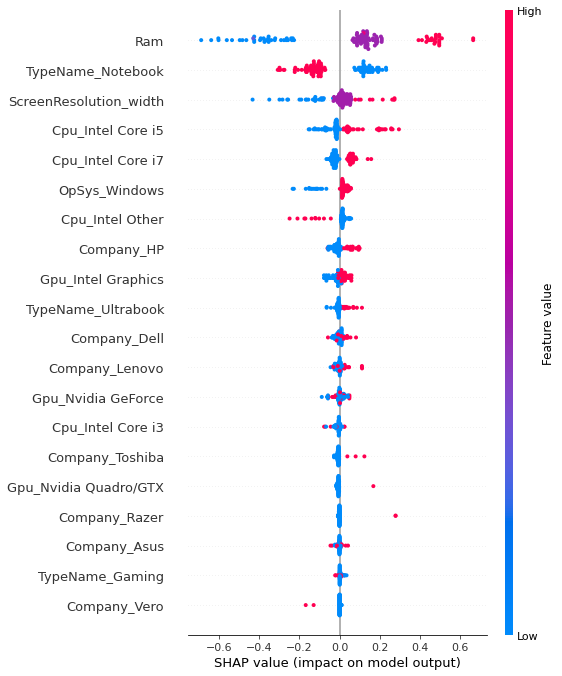

In [46]:
import shap
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Теперь закодируем категориальные признаки с помощью LabelEncoder. С одной стороны, ожидается ухудшение качества, так как мы введем предпосылки (связанные со свойствами чисел), которые не выполняются в реальности. С другой стороны, мы сможем вывести важность признаков, и качественно сравнить категориальные признаки с непрерывными (насколько эти признаки помогают улучшить показатели информационных критериев при разбиении дерева)

In [47]:
from sklearn.preprocessing import LabelEncoder
df_short_tmp = df_short.copy()
df_short_tmp['Price_euros'] = np.log(df_short_tmp['Price_euros'])
df_short_tmp['Ram'] = np.log(df_short_tmp['Ram'])
df_short_tmp['ScreenResolution_width'] = np.log(df_short_tmp['ScreenResolution_width'])
X = df_short_tmp.drop('Price_euros', axis=1)
y = df_short_tmp['Price_euros']

cat_features = X.select_dtypes(include=['object']).columns
label_encoders = {}
for feature in cat_features:
    label_encoders[feature] = LabelEncoder()
    X[feature] = label_encoders[feature].fit_transform(X[feature].astype(str))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test_quality_measure = np.exp(y_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred = forest.predict(X_test)
y_pred = np.exp(y_pred)
r2 = r2_score(y_test_quality_measure, y_pred)
mse = mean_squared_error(y_test_quality_measure, y_pred)
mape = MAPE(y_test_quality_measure, y_pred)
print('R^2 that we got: ', r2)
print()
print('MSE that we got: ', mse)
print()
print('MAPE that we got: ', mape)

R^2 that we got:  0.8108670743366946

MSE that we got:  72230.4344396412

MAPE that we got:  19.362158941817935


Feature: 0, Score: 0.06410
Feature: 1, Score: 0.07186
Feature: 2, Score: 0.11317
Feature: 3, Score: 0.58229
Feature: 4, Score: 0.02820
Feature: 5, Score: 0.03156
Feature: 6, Score: 0.10882


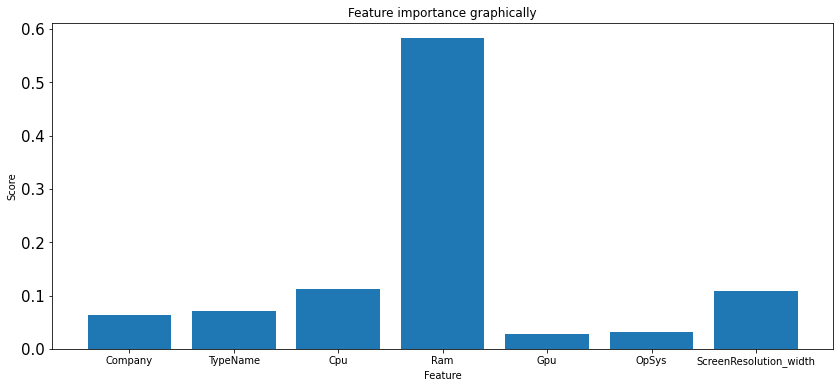

In [48]:
# https://towardsdatascience.com/how-to-interpret-machine-learning-models-part-1-easy-978ddade7ada
importance = forest.feature_importances_
plt.figure(figsize=(14,6))
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar(X_train.columns, importance)
plt.yticks(fontsize=15)
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('Feature importance graphically')
plt.show()

Интерпретация - в отчете

# Источники:

1) https://github.com/pvpogorelova/ec_metrics/blob/main/Sem_08.ipynb - основа построения OLS-модели

2) https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0 - проверка предпосылок ТГМ

3) https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html - работа с квантильной регрессией, сравнение результатов квантильной регрессии с результатами обычной регрессии

4) https://sease.io/2020/07/explaining-learning-to-rank-models-with-tree-shap.html - немного про интерпретируемый ML

5) https://towardsdatascience.com/how-to-interpret-machine-learning-models-part-1-easy-978ddade7ada - важность признаков для случайного леса